In [ ]:
import pandas as pd

In [ ]:
!unzip /content/drive/MyDrive/data/data.zip

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data/ann.csv')
df

filename  width  height                  class       xmin  \
0     batch_1/000006.jpg   1537    2049                 Bottle   517.0000   
1     batch_1/000008.jpg   1537    2049                 Carton     1.0000   
2     batch_1/000008.jpg   1537    2049                 Carton   531.0000   
3     batch_1/000010.jpg   1537    2049                 Bottle   632.0000   
4     batch_1/000010.jpg   1537    2049             Bottle cap   632.0000   
...                  ...    ...     ...                    ...        ...   
4779  batch_9/000098.jpg   1824    4000                 Carton   228.7143   
4780  batch_9/000098.jpg   1824    4000             Bottle cap  1041.3334   
4781  batch_9/000099.jpg   1824    4000  Plastic bag & wrapper   862.0274   
4782  batch_9/000099.jpg   1824    4000                 Carton   966.0000   
4783  batch_9/000099.jpg   1824    4000                 Bottle  1125.0000   

           ymin       xmax    ymax  
0      127.0000  1984.0000  3371.0  
1      457.0000  2966.0000  3568.0  
2      292.0000  2543.0000  2721.0  
3      987.0000  2037.0000  2423.0  
4      989.0000  1581.0000  2100.0  
...         ...        ...     ...  
4779  1550.0476  2831.9999  4579.0  
4780  1721.7142  1965.0000  4138.0  
4781  1331.2500  2329.9726  4612.5  
4782  1996.0000  2035.0000  4336.0  
4783  1858.0000  2058.0000  4510.0  

[4784 rows x 8 columns]

In [ ]:
df.columns=['filename', 'width', 'height', 'class_name', 'x', 'y', 'w', 'h']

In [ ]:
df['w'] = df['w'] - df['width']
df['h'] = df['h'] - df['height']

In [ ]:
df['w'] = df['w'] + df['x']
df['h'] = df['h'] + df['y']

In [ ]:
!git clone https://github.com/harshatejas/pytorch_custom_object_detection.git

Cloning into 'pytorch_custom_object_detection'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 447 (delta 17), reused 13 (delta 13), pack-reused 428
Receiving objects: 100% (447/447), 36.73 MiB | 16.52 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#from engine import train_one_epoch, evaluate
#import utils
#import transforms as T

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Hyperparameters
test_set_length = 200 		 # Test set (number of images)
train_batch_size = 2  		 # Train batch size
test_batch_size = 1    		 # Test batch size
num_classes = 28      		 # Number of classes
learning_rate = 0.005  		 # Learning rate
num_epochs = 10

In [ ]:
def create_label_txt(data):
	labels = data['class_name'].unique()

	labels_dict = {}

	# Creat dictionary from array
	for index, label in enumerate(labels):
		labels_dict.__setitem__(index, label)

	# We need to create labels.txt and write labels dictionary into it
	with open('labels.txt', 'w') as f:
		f.write(str(labels_dict))

	return labels_dict

In [ ]:
labels_dict=create_label_txt(df)

In [ ]:
def parse_one_annot(data, filename, labels_dict):
  class_names = data['class_name'].unique()
  classes_df = data[data["filename"] == filename]["class_name"]
  classes_array = classes_df.to_numpy()
  boxes_df = data[data["filename"] == filename][["x", "y", "w", "h"]]
  boxes_array = boxes_df.to_numpy()

  classes = []
  for key, value in labels_dict.items():
    for i in classes_array:
      if i == value:
        classes.append(key)

  classes = tuple(classes)
  return boxes_array, classes

In [ ]:
def get_model(num_classes):

	# Load an pre-trained object detectin model (in this case faster-rcnn)
	model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

	# Number of input features
	in_features = model.roi_heads.box_predictor.cls_score.in_features

	# Replace the pre-trained head with a new head
	model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

	return model

In [ ]:
def get_transforms(train):

	transforms = []

	# Convert numpy image to PyTorch Tensor
	transforms.append(T.ToTensor())

	if train:
		# Data augmentation
		transforms.append(T.RandomHorizontalFlip(0.5))

	return T.Compose(transforms)

In [ ]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
                fullPath = fullPath.replace('/content/data/', '')
                allFiles.append(fullPath)
    return allFiles

In [ ]:
import re
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, dataset_dir, data, labels_dict, transforms = None):
    self.dataset_dir = dataset_dir
    self.data = data
    self.transforms = transforms
    self.labels_dict = labels_dict
    files = getListOfFiles(os.path.join(self.dataset_dir))
    p = re.compile('batch')
    l2 = [ s for s in files if p.match(s) ]
    self.imgs = sorted(l2)

  def __getitem__(self, index):
    image_path = os.path.join(self.dataset_dir, self.imgs[index])
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    box_array, classes = parse_one_annot(self.data, self.imgs[index], self.labels_dict)
    boxes = torch.as_tensor(box_array, dtype = torch.float32)

    labels = torch.tensor(classes, dtype=torch.int64)
    image_id = torch.tensor([index])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    iscrowd = torch.tensor(classes, dtype=torch.int64)
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      image, target = self.transforms(image, target)
    return image, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
dataset = MyDataset(dataset_dir = "/content/data/", data = df,
                        labels_dict = labels_dict, transforms = get_transforms(train = True))

dataset_test = MyDataset(dataset_dir = "/content/data/", data = df,
                        labels_dict = labels_dict, transforms = get_transforms(train = False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-test_set_length])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_set_length:])


data_loader = torch.utils.data.DataLoader(dataset, batch_size = train_batch_size, shuffle = True,
                num_workers = 8, collate_fn = utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = test_batch_size, shuffle = False,
                num_workers = 8, collate_fn = utils.collate_fn)

print(f'We have: {len(indices)} images in the dataset, {len(dataset)} are training images and {len(dataset_test)} are testing images')

We have: 1500 images in the dataset, 1300 are training images and 200 are testing images


In [ ]:
model = get_model(num_classes)
model.to(device = device)

# Construct the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = learning_rate, momentum = 0.9, weight_decay = 0.0005)

# Learning rate scheduler decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

for epoch in range(num_epochs):

    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq = 10)
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_test, device = device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 272MB/s]


Epoch: [0]  [  0/650]  eta: 1:54:07  lr: 0.000013  loss: 3.4685 (3.4685)  loss_classifier: 3.2641 (3.2641)  loss_box_reg: 0.1559 (0.1559)  loss_objectness: 0.0477 (0.0477)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 10.5351  data: 1.5666  max mem: 2986
Epoch: [0]  [ 10/650]  eta: 0:13:03  lr: 0.000090  loss: 3.4685 (3.4772)  loss_classifier: 3.1217 (3.0430)  loss_box_reg: 0.1947 (0.1989)  loss_objectness: 0.0477 (0.2057)  loss_rpn_box_reg: 0.0028 (0.0296)  time: 1.2236  data: 0.1833  max mem: 3782
Epoch: [0]  [ 20/650]  eta: 0:08:14  lr: 0.000167  loss: 3.1562 (3.0059)  loss_classifier: 2.3996 (2.2794)  loss_box_reg: 0.1893 (0.1988)  loss_objectness: 0.0947 (0.4786)  loss_rpn_box_reg: 0.0065 (0.0492)  time: 0.2968  data: 0.0412  max mem: 3782
Epoch: [0]  [ 30/650]  eta: 0:06:30  lr: 0.000244  loss: 1.2970 (2.3239)  loss_classifier: 0.7543 (1.6696)  loss_box_reg: 0.1749 (0.2040)  loss_objectness: 0.0853 (0.4009)  loss_rpn_box_reg: 0.0158 (0.0494)  time: 0.3020  data: 0.0433  max mem: 3782

In [ ]:
if not os.path.exists('/content/models'):
    os.mkdir('/content/models')

# Save the model state
torch.save(model.state_dict(), '/content/models' + "/model.pth")


In [ ]:
loaded_model = get_model(28)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/model-2.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 407MB/s]


<All keys matched successfully>

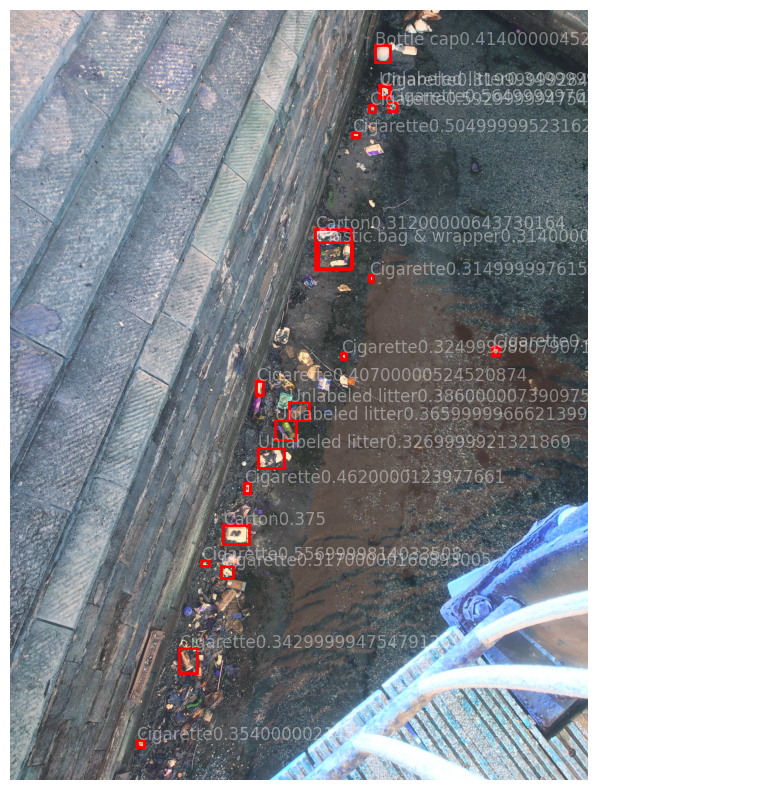

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image = cv2.imread('/content/data/batch_6/000072.JPG')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = torchvision.transforms.ToTensor()(img)

loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)

for element in range(len(prediction[0]['boxes'])):
    x, y, w, h = prediction[0]['boxes'][element].cpu().numpy().astype(int)
    score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals=3)
    label_index = prediction[0]['labels'][element].cpu().numpy()
    label = labels_dict[int(label_index)]
    if score > 0.3:
        rect = patches.Rectangle((x, y), w-x, h-y, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        text = "{}{}".format(label,score)
        ax.text(x, y, text, fontsize=12, color='white',alpha=0.4)

plt.axis('off')
plt.show()


In [ ]:
df['filename'].value_counts()

batch_6/000072.JPG     90
batch_8/000021.jpg     54
batch_12/000061.jpg    38
batch_13/000025.jpg    37
batch_12/000062.jpg    37
                       ..
batch_4/000022.JPG      1
batch_4/000023.JPG      1
batch_4/000025.JPG      1
batch_4/000026.JPG      1
batch_1/000006.jpg      1
Name: filename, Length: 1500, dtype: int64

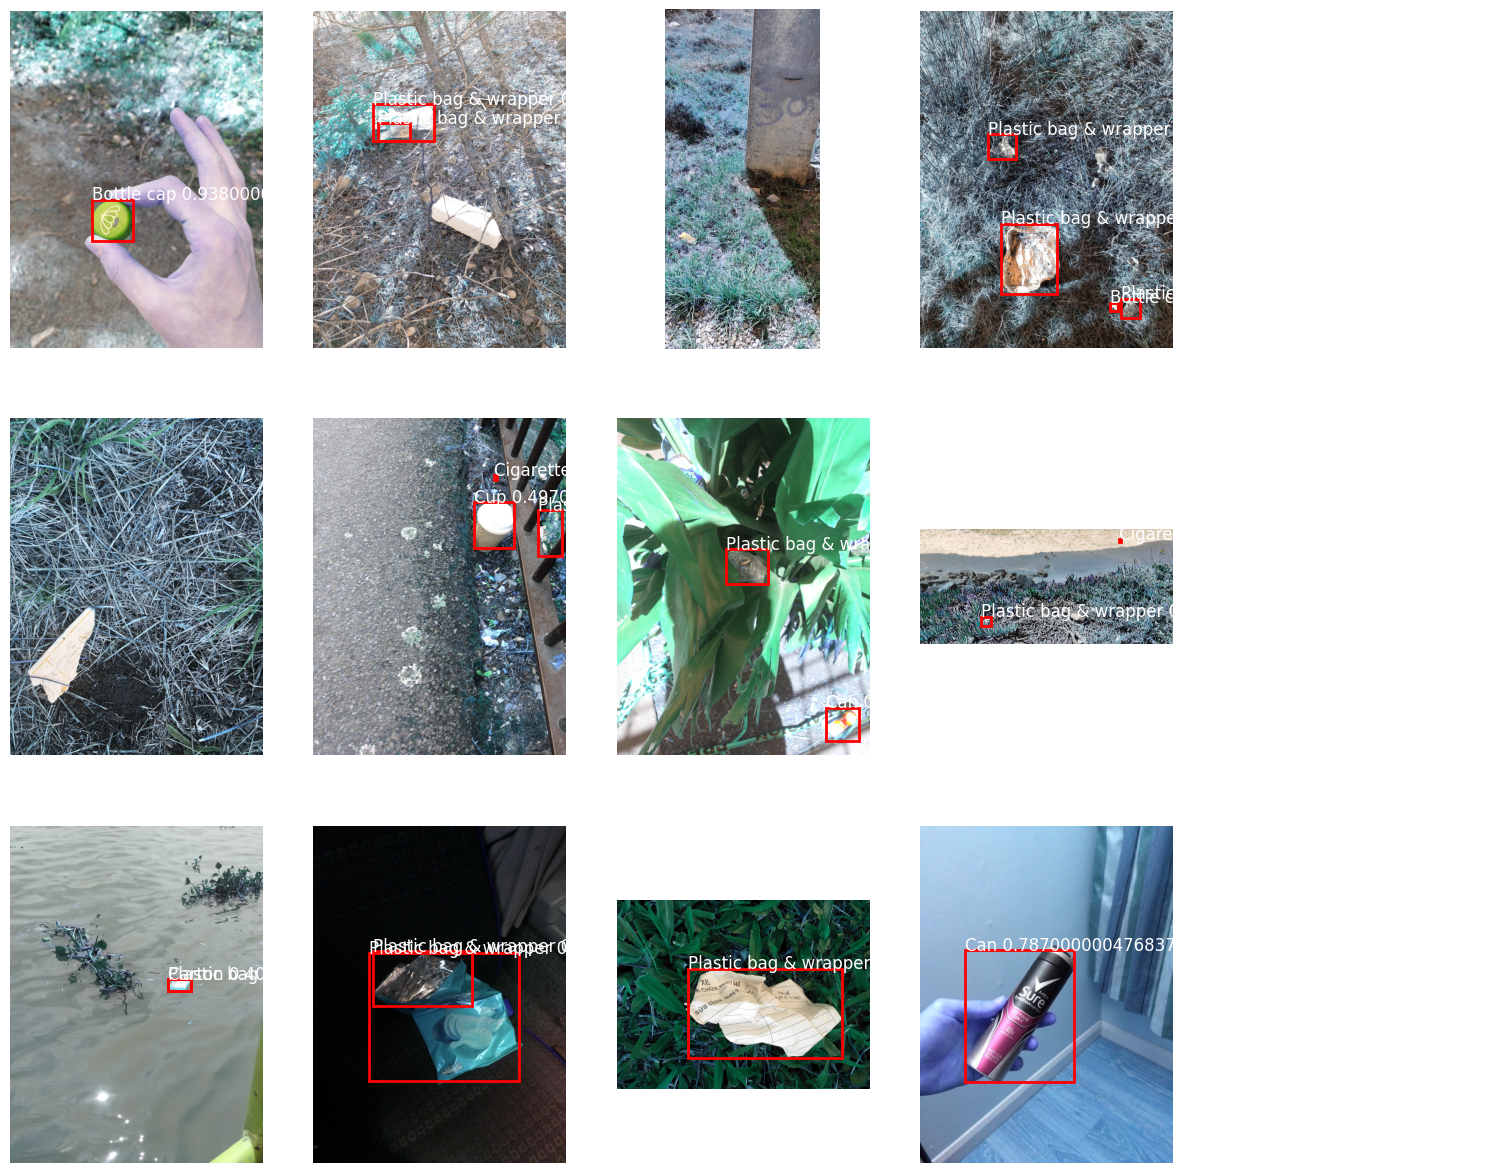

In [ ]:
import random

image_paths=df['filename'].unique()
random.shuffle(image_paths)

# Create a subplot for 12 images
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
axes = axes.ravel()

for i in range(12):
    image_path = image_paths[i]
    image = cv2.imread('/content/data/'+image_path)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = torchvision.transforms.ToTensor()(img)

    with torch.no_grad():
        prediction = loaded_model([img])

    ax = axes[i]
    ax.imshow(image)

    for element in range(len(prediction[0]['boxes'])):
        x, y, w, h = prediction[0]['boxes'][element].cpu().numpy().astype(int)
        score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals=3)
        label_index = prediction[0]['labels'][element].cpu().numpy()
        label = labels_dict[int(label_index)]

        if score > 0.4:
            rect = patches.Rectangle((x, y), w-x, h-y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            text = f"{label} {round(score,3)}"
            ax.text(x, y, text, fontsize=12, color='white')

    ax.axis('off')

# Remove empty subplots if there are fewer than 12 images
for i in range(len(image_paths), 12):
    fig.delaxes(axes[i])

plt.show()

In [ ]:
pred=[]
y_true=[]
loaded_model.eval()
with torch.no_grad():
    for i, x in enumerate(data_loader_test):
        pred.append(loaded_model(x[0]))
        y_true.append(x[1])

KeyboardInterrupt: ignored

In [ ]:
yy=[]
y=[]
for i in y_true:
  y.append(i[0]['labels'][0].numpy())

for i in pred:
  yy.append(i[0]['labels'][0].numpy())

In [ ]:
y=np.array(y).flatten()

In [ ]:
yy=np.array(yy).flatten()

In [ ]:
y

array([ 0,  2,  2,  6, 15,  0, 21,  8,  6, 15,  8,  6,  5,  6, 10,  5, 25,
        0, 25,  1,  1,  0,  0,  5,  0,  0, 20,  5,  0,  0, 11,  1,  5,  2,
        6, 10,  7,  5,  2,  6,  6,  6,  5, 27,  8,  6,  7,  8,  0,  1,  1,
        2,  0,  7,  3,  6,  0,  7,  1,  6,  6, 12,  2,  9,  6,  0,  5,  6,
        1,  0,  1,  0,  1,  9,  8,  6,  6,  6,  0,  8,  0,  6,  6,  7,  6,
        9,  6,  1,  1,  2,  0,  0])